In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from plotly.subplots import make_subplots
from scipy.stats import t
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
station = "Hot"

In [3]:
data = xr.load_dataset(f"./products/{station}_obs_filtered.zarr", engine="zarr")
data

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 514, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 4kB 1994-02-17 1994-02-18 ... 2022-09-01
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB 0.4208 ... 2.282
    night      (time, latitude, longitude, layer) float64 4kB 1.48 ... 2.425
Attributes:
    creation date:  2024-10-13T20:03:40.309826
    layer:          epipelagic
    station:        Hot

## Number of samples


In [4]:
# Calculer les comptes mensuels
day_counts_month = data.groupby("time.month").count().day[:, 0, 0, 0]
night_counts_month = data.groupby("time.month").count().night[:, 0, 0, 0]

day_counts_month_cumsum = day_counts_month.cumsum()
night_counts_month_cumsum = night_counts_month.cumsum()

# Calculer les comptes annuels
day_counts_year = data.groupby("time.year").count().day[:, 0, 0, 0]
night_counts_year = data.groupby("time.year").count().night[:, 0, 0, 0]

day_counts_year_cumsum = day_counts_year.cumsum()
night_counts_year_cumsum = night_counts_year.cumsum()

# Créer la figure avec des subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Yearly Data", "Monthly Data"))

# Ajouter les traces pour les données annuelles
fig.add_trace(go.Scatter(x=day_counts_year["year"], y=day_counts_year, mode="lines+markers", name="Day"), row=1, col=1)
fig.add_trace(
    go.Scatter(x=night_counts_year["year"], y=night_counts_year, mode="lines+markers", name="Night"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=day_counts_year_cumsum["year"],
        y=day_counts_year_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_year_cumsum["year"],
        y=night_counts_year_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)

# Ajouter les traces pour les données mensuelles
fig.add_trace(
    go.Scatter(x=day_counts_month["month"], y=day_counts_month, mode="lines+markers", name="Day"), row=1, col=2
)
fig.add_trace(
    go.Scatter(x=night_counts_month["month"], y=night_counts_month, mode="lines+markers", name="Night"), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=day_counts_month_cumsum["month"],
        y=day_counts_month_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_month_cumsum["month"],
        y=night_counts_month_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)

# Mettre à jour la mise en page avec le menu déroulant
fig.update_layout(
    title=f"Nb of samples during day and night by year and month at {station}",
    xaxis_title="Year",
    yaxis_title="Nb of samples",
    legend_title="Legend",
    xaxis={"showgrid": True},
    yaxis={"showgrid": True},
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, True, False, False, True, True, False, False]}],
                    "label": "Non-Cumulative",
                    "method": "update",
                },
                {
                    "args": [{"visible": [False, False, True, True, False, False, True, True]}],
                    "label": "Cumulative",
                    "method": "update",
                },
            ],
            "direction": "down",
            "showactive": True,
        }
    ],
)
# wider layout
fig.update_layout(width=1100, height=600)
fig.show()

## Computing the trend


/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_12153/70799619.py:6: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_12153/70799619.py:13: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be

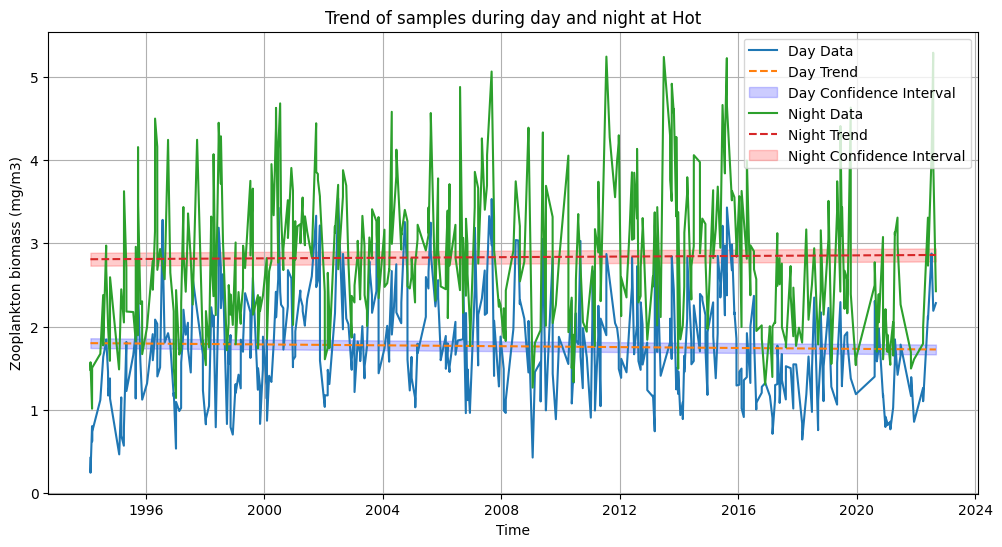

In [5]:
# Extraire les données de jour et de nuit
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

# Extraire les indices de temps en jours
time_indices = (day_data["time"] - day_data["time"][0]).astype("timedelta64[D]").astype(int)

# Ajuster une ligne droite aux données de jour
day_trend = np.polyfit(time_indices, day_data, 1)
day_trend_line = np.polyval(day_trend, time_indices)

# Ajuster une ligne droite aux données de nuit
night_time_indices = (night_data["time"] - night_data["time"][0]).astype("timedelta64[D]").astype(int)
night_trend = np.polyfit(night_time_indices, night_data, 1)
night_trend_line = np.polyval(night_trend, night_time_indices)

# Calculer l'erreur standard des tendances de jour et de nuit
day_std_error = np.std(day_data - day_trend_line) / np.sqrt(len(day_data))
night_std_error = np.std(night_data - night_trend_line) / np.sqrt(len(night_data))

# Définir le niveau de confiance (par exemple, 95%)
confidence_level = 0.95
degrees_freedom_day = len(day_data) - 2
degrees_freedom_night = len(night_data) - 2

# Calculer la valeur critique t pour le niveau de confiance et les degrés de liberté
t_critical_day = t.ppf((1 + confidence_level) / 2, degrees_freedom_day)
t_critical_night = t.ppf((1 + confidence_level) / 2, degrees_freedom_night)

# Calculer l'intervalle de confiance
day_confidence_interval = float(t_critical_day * day_std_error)
night_confidence_interval = float(t_critical_night * night_std_error)

# Tracer les données et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_trend_line, label="Day Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_trend_line - day_confidence_interval,
    day_trend_line + day_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_trend_line, label="Night Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_trend_line - night_confidence_interval,
    night_trend_line + night_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Confidence Interval",
)

plt.legend()
plt.title(f"Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

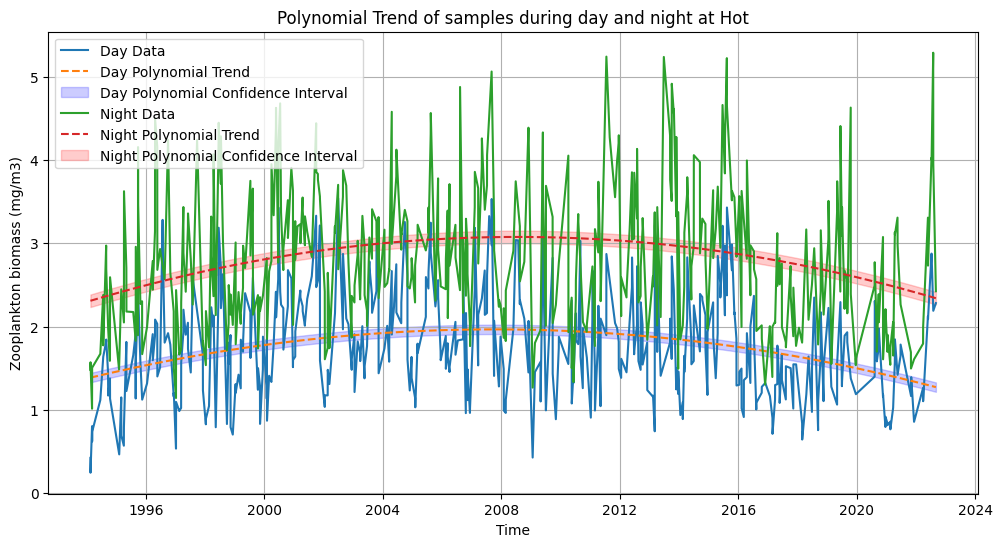

In [6]:
# Ajuster une fonction polynomiale de degré 2 aux données de jour
day_poly_trend = np.polyfit(time_indices, day_data, 2)
day_poly_trend_line = np.polyval(day_poly_trend, time_indices)

# Ajuster une fonction polynomiale de degré 2 aux données de nuit
night_poly_trend = np.polyfit(night_time_indices, night_data, 2)
night_poly_trend_line = np.polyval(night_poly_trend, night_time_indices)

# Calculer l'erreur standard des tendances polynomiales de jour et de nuit
day_poly_std_error = np.std(day_data - day_poly_trend_line) / np.sqrt(len(day_data))
night_poly_std_error = np.std(night_data - night_poly_trend_line) / np.sqrt(len(night_data))

# Calculer l'intervalle de confiance pour les tendances polynomiales
day_poly_confidence_interval = float(t_critical_day * day_poly_std_error)
night_poly_confidence_interval = float(t_critical_night * night_poly_std_error)

# Tracer les données et les intervalles de confiance pour les tendances polynomiales
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_poly_trend_line, label="Day Polynomial Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_poly_trend_line - day_poly_confidence_interval,
    day_poly_trend_line + day_poly_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Polynomial Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_poly_trend_line, label="Night Polynomial Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_poly_trend_line - night_poly_confidence_interval,
    night_poly_trend_line + night_poly_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Polynomial Confidence Interval",
)

plt.legend()
plt.title(f"Polynomial Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Group data by week


In [7]:
grouped_data = xr.Dataset({"day": data.day, "night": data.night})

# Calculer les moyennes mensuelles des données détrendées
grouped_data = grouped_data.groupby("time.week").mean()
grouped_data

# ajouter des nan pour les semaines manquantes
grouped_data = grouped_data.reindex(week=np.arange(1, 53))
grouped_data

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/dataset.py:227: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.



<xarray.Dataset> Size: 1kB
Dimensions:    (week: 52, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week, latitude, longitude, layer) float64 416B 0.9044 ... 1.508
    night      (week, latitude, longitude, layer) float64 416B nan ... 2.806

## Raw data, no smoothing


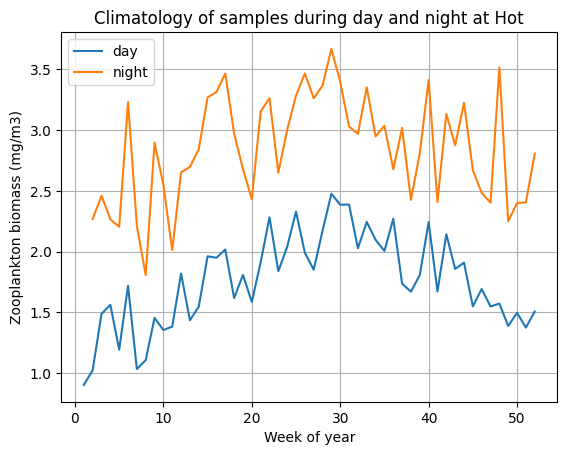

In [8]:
grouped_data.day.dropna("week").plot(label="day")
grouped_data.night.dropna("week").plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Week of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

In [9]:
grouped_data_less = grouped_data.assign_coords(week=grouped_data.week - 52)
grouped_data_more = grouped_data.assign_coords(week=grouped_data.week + 52)

gathered_data = xr.concat([grouped_data_less, grouped_data, grouped_data_more], dim="week")
gathered_data

<xarray.Dataset> Size: 4kB
Dimensions:    (week: 156, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * week       (week) int64 1kB -51 -50 -49 -48 -47 -46 ... 100 101 102 103 104
Data variables:
    day        (week, latitude, longitude, layer) float64 1kB 0.9044 ... 1.508
    night      (week, latitude, longitude, layer) float64 1kB nan ... 2.806

## Smooth


In [10]:
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=("Day", "Night"),
    vertical_spacing=0.1,
    x_title="Week of year",
    y_title="Zooplankton biomass (mg/m3)",
)
fig.add_trace(
    go.Scatter(x=gathered_data.week.data.flatten(), y=gathered_data.day.data.flatten(), mode="lines", name="day"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=gathered_data.week.data.flatten(), y=gathered_data.night.data.flatten(), mode="lines", name="night"),
    row=2,
    col=1,
)
for frac in [0.05, 0.1]:
    lowess_day = lowess(gathered_data.day.data.flatten(), gathered_data.week.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_day[:, 0], y=lowess_day[:, 1], mode="lines", name=f"day lowess {frac}"), row=1, col=1
    )

    lowess_night = lowess(gathered_data.night.data.flatten(), gathered_data.week.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_night[:, 0], y=lowess_night[:, 1], mode="lines", name=f"night lowess {frac}"), row=2, col=1
    )

fig.update_layout(title=f"Day and night zooplankton observations at {station}")

fig.show()

In [11]:
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=("Day", "Night"),
    vertical_spacing=0.1,
    x_title="Week of year",
    y_title="Zooplankton biomass (mg/m3)",
)
fig.add_trace(
    go.Scatter(x=gathered_data.week.data.flatten(), y=gathered_data.day.data.flatten(), mode="lines", name="day"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=gathered_data.week.data.flatten(), y=gathered_data.night.data.flatten(), mode="lines", name="night"),
    row=2,
    col=1,
)
for frac in [0.05, 0.1, 0.2]:
    lowess_day = lowess(gathered_data.day.data.flatten(), gathered_data.week.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_day[:, 0], y=lowess_day[:, 1], mode="lines", name=f"day lowess {frac}"), row=1, col=1
    )

    lowess_night = lowess(gathered_data.night.data.flatten(), gathered_data.week.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_night[:, 0], y=lowess_night[:, 1], mode="lines", name=f"night lowess {frac}"), row=2, col=1
    )
    gathered_data[f"day_lowess_{frac}"] = xr.DataArray(
        lowess_day[:, 1], dims=["week"], coords={"week": lowess_day[:, 0]}, attrs={"frac": frac, "units": "mg/m3"}
    )
    gathered_data[f"night_lowess_{frac}"] = xr.DataArray(
        lowess_night[:, 1], dims=["week"], coords={"week": lowess_night[:, 0]}, attrs={"frac": frac, "units": "mg/m3"}
    )

fig.update_layout(
    title=f"Day and night zooplankton observations at {station}",
    height=800,
)
# dark mode
fig.update_layout(template="plotly_dark")

fig.show()

In [12]:
gathered_data = gathered_data.sel(week=slice(1, 52))
gathered_data

<xarray.Dataset> Size: 4kB
Dimensions:            (latitude: 1, layer: 1, longitude: 1, week: 52)
Coordinates:
  * latitude           (latitude) float64 8B 22.75
  * layer              (layer) int64 8B 0
  * longitude          (longitude) int64 8B -158
  * week               (week) float64 416B 1.0 2.0 3.0 4.0 ... 50.0 51.0 52.0
Data variables:
    day                (week, latitude, longitude, layer) float64 416B 0.9044...
    night              (week, latitude, longitude, layer) float64 416B nan .....
    day_lowess_0.05    (week) float64 416B 1.206 1.221 1.305 ... 1.397 1.272
    night_lowess_0.05  (week) float64 416B nan 2.427 2.346 ... 2.405 2.467 2.455
    day_lowess_0.1     (week) float64 416B 1.359 1.345 1.328 ... 1.393 1.371
    night_lowess_0.1   (week) float64 416B nan 2.381 2.37 ... 2.463 2.43 2.41
    day_lowess_0.2     (week) float64 416B 1.451 1.436 1.428 ... 1.494 1.471
    night_lowess_0.2   (week) float64 416B nan 2.504 2.501 ... 2.576 2.553 2.532

## Duplicating observation across the entire time period


In [13]:
value_by_week = (
    gathered_data.to_dataframe().reset_index().drop(columns=["latitude", "longitude", "layer"]).set_index("week")
)
value_by_week.head()

,day,night,day_lowess_0.05,night_lowess_0.05,day_lowess_0.1,night_lowess_0.1,day_lowess_0.2,night_lowess_0.2
week,,,,,,,,
1.0,0.904391,NaN,1.205966,NaN,1.358651,NaN,1.450965,NaN
2.0,1.025472,2.268514,1.220582,2.427093,1.345371,2.381439,1.436420,2.504449
3.0,1.488800,2.460143,1.305314,2.345884,1.327769,2.370180,1.428092,2.500574
4.0,1.563200,2.267207,1.406398,2.289218,1.315375,2.366794,1.426427,2.504548
5.0,1.194098,2.204490,1.405385,2.242723,1.315648,2.363517,1.431212,2.516737


In [14]:
week_by_day = (
    pd.date_range(start=data.indexes["time"][0], end=data.indexes["time"][-1], freq="W")
    .isocalendar()
    .drop(columns=["day", "year"])
)
week_by_day.head()

,week
1994-02-20,7
1994-02-27,8
1994-03-06,9
1994-03-13,10
1994-03-20,11


In [15]:
aggregated_smoothed = week_by_day.join(value_by_week, on="week").drop(columns=["week"])
aggregated_smoothed.index.name = "time"
aggregated_smoothed

,day,night,day_lowess_0.05,night_lowess_0.05,day_lowess_0.1,night_lowess_0.1,day_lowess_0.2,night_lowess_0.2
time,,,,,,,,
1994-02-20,1.034828,2.210380,1.250939,2.188741,1.352860,2.382998,1.456044,2.559205
1994-02-27,1.108564,1.807014,1.243465,2.303255,1.372291,2.416614,1.474098,2.585610
1994-03-06,1.455771,2.896633,1.290477,2.400424,1.389541,2.439189,1.495687,2.614169
1994-03-13,1.355485,2.547614,1.403811,2.495307,1.422558,2.501400,1.520559,2.644234
1994-03-20,1.384094,2.012060,1.487843,2.540278,1.478410,2.588309,1.548488,2.675211
...,...,...,...,...,...,...,...,...
2022-07-31,2.385309,3.396641,2.352177,3.319392,2.202480,3.256266,2.073808,3.101136
2022-08-07,2.387164,3.029025,2.292300,3.195475,2.204906,3.212118,2.073387,3.093619
2022-08-14,2.027351,2.967397,2.222402,3.113047,2.195375,3.154328,2.069328,3.083849


In [16]:
climato_observations = xr.Dataset.from_dataframe(aggregated_smoothed)
for var in climato_observations:
    climato_observations[var].attrs = {"units": "mg/m3"}
climato_observations.attrs = {
    "desc": "Aggregated and smoothed observations using lowess filtre.",
}
climato_observations

<xarray.Dataset> Size: 107kB
Dimensions:            (time: 1489)
Coordinates:
  * time               (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
Data variables:
    day                (time) float64 12kB 1.035 1.109 1.456 ... 2.245 2.097
    night              (time) float64 12kB 2.21 1.807 2.897 ... 2.967 3.35 2.948
    day_lowess_0.05    (time) float64 12kB 1.251 1.243 1.29 ... 2.145 2.119
    night_lowess_0.05  (time) float64 12kB 2.189 2.303 2.4 ... 3.113 3.071 3.04
    day_lowess_0.1     (time) float64 12kB 1.353 1.372 1.39 ... 2.159 2.102
    night_lowess_0.1   (time) float64 12kB 2.383 2.417 2.439 ... 3.085 3.015
    day_lowess_0.2     (time) float64 12kB 1.456 1.474 1.496 ... 2.061 2.048
    night_lowess_0.2   (time) float64 12kB 2.559 2.586 2.614 ... 3.07 3.051
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

## Plot final results


In [17]:
day_names = ["day", "day_lowess_0.05", "day_lowess_0.1", "day_lowess_0.2"]
night_names = ["night", "night_lowess_0.05", "night_lowess_0.1", "night_lowess_0.2"]

fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# -------------------------------------------------------------------------------------------------------------------- #

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# -------------------------------------------------------------------------------------------------------------------- #

for day, night in zip(day_names, night_names):
    # Ajouter les données de jour
    fig.add_trace(
        go.Scatter(
            x=aggregated_smoothed.index,
            y=aggregated_smoothed[day],
            mode="lines",
            name=day,
        ),
        row=1,
        col=1,
    )

    # Ajouter les données de nuit
    fig.add_trace(
        go.Scatter(
            x=aggregated_smoothed.index,
            y=aggregated_smoothed[night],
            mode="lines",
            name=night,
        ),
        row=2,
        col=1,
    )

# -------------------------------------------------------------------------------------------------------------------- #

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : With Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
    # night mode
    # template="plotly_dark",
)

fig.show()

In [18]:
# fig.write_html(f"Hot_climato_observations_filtered.html")

## Export


In [19]:
climato_observations

<xarray.Dataset> Size: 107kB
Dimensions:            (time: 1489)
Coordinates:
  * time               (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
Data variables:
    day                (time) float64 12kB 1.035 1.109 1.456 ... 2.245 2.097
    night              (time) float64 12kB 2.21 1.807 2.897 ... 2.967 3.35 2.948
    day_lowess_0.05    (time) float64 12kB 1.251 1.243 1.29 ... 2.145 2.119
    night_lowess_0.05  (time) float64 12kB 2.189 2.303 2.4 ... 3.113 3.071 3.04
    day_lowess_0.1     (time) float64 12kB 1.353 1.372 1.39 ... 2.159 2.102
    night_lowess_0.1   (time) float64 12kB 2.383 2.417 2.439 ... 3.085 3.015
    day_lowess_0.2     (time) float64 12kB 1.456 1.474 1.496 ... 2.061 2.048
    night_lowess_0.2   (time) float64 12kB 2.559 2.586 2.614 ... 3.07 3.051
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

In [20]:
climato_observations = climato_observations.expand_dims(
    latitude=[data.latitude[0]], longitude=[data.longitude[0]], layer=[data.layer[0]]
)
climato_observations = climato_observations.transpose("time", "latitude", "longitude", "layer")

In [21]:
climato_observations.latitude.attrs = data.latitude.attrs
climato_observations.longitude.attrs = data.longitude.attrs
climato_observations.layer.attrs = data.layer.attrs
climato_observations.time.attrs = data.time.attrs
climato_observations.day.attrs = data.day.attrs
climato_observations.night.attrs = data.night.attrs
climato_observations

<xarray.Dataset> Size: 107kB
Dimensions:            (latitude: 1, longitude: 1, layer: 1, time: 1489)
Coordinates:
  * latitude           (latitude) float64 8B 22.75
  * longitude          (longitude) int64 8B -158
  * layer              (layer) int64 8B 0
  * time               (time) datetime64[ns] 12kB 1994-02-20 ... 2022-08-28
Data variables:
    day                (time, latitude, longitude, layer) float64 12kB 1.035 ...
    night              (time, latitude, longitude, layer) float64 12kB 2.21 ....
    day_lowess_0.05    (time, latitude, longitude, layer) float64 12kB 1.251 ...
    night_lowess_0.05  (time, latitude, longitude, layer) float64 12kB 2.189 ...
    day_lowess_0.1     (time, latitude, longitude, layer) float64 12kB 1.353 ...
    night_lowess_0.1   (time, latitude, longitude, layer) float64 12kB 2.383 ...
    day_lowess_0.2     (time, latitude, longitude, layer) float64 12kB 1.456 ...
    night_lowess_0.2   (time, latitude, longitude, layer) float64 12kB 2.559 ...
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

In [22]:
climato_observations.to_zarr(f"./products/{station}_climato_zoo.zarr", mode="w")